In [2]:
## Planned datasets - Image (different image sizes/ Different number of classes), 
##                    Classification (Different feature size / Different number of classes)

## Planned models - FC/Dropout, CNN(LeNet)/Resnet/Inception (Maybe include attention)

## Predict running time based on Layers/No of params/FLOPs
## Calculate total number of computations (based on dataset/model size)
## Calculate approx cost on GCP (or any cloud platform)

import tensorflow as tf
import numpy as np
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

import warnings
warnings.filterwarnings("ignore")

In [28]:
def create_fc(config):
    config['hidden_layers'] = len(config['layers'])
    input = tf.keras.layers.Input(shape=config['input_shape'])
    if config['input_dropout'] is not None:
        x = tf.keras.layers.Dropout(config['input_dropout'])(input)
    else:
        x = input
    for i in range(config['hidden_layers']):
        dim = config['layers'][i]
        act = 'relu'
        x = tf.keras.layers.Dense(dim,activation=act)(x)
        if config['dropout'] is not None:
            x = tf.keras.layers.Dropout(config['dropout'])(x)
            
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Dense(config['output_shape'],activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=x)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                                optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                                metrics=['accuracy'])
    return model

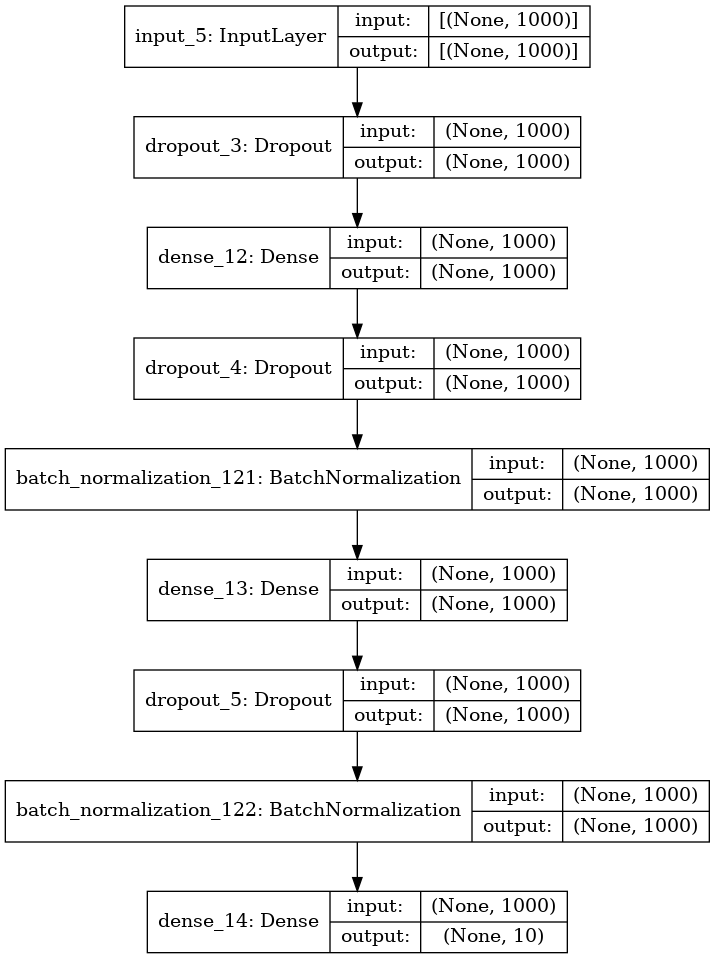

In [29]:
fc_config = dict()
fc_config['input_shape'] = 1000
fc_config['output_shape'] = 10
fc_config['input_dropout'] = 0.2
fc_config['dropout'] = 0.5
fc_config['hidden_layers'] = 2
fc_config['layers'] = [1000,1000]
# Output activation = always sigmoid
# All hidden layers have same dropout
# All hidden layers activated with ReLU
# Optimizer is always sgd with lr = 0.01 and momentum=0.9

fc_model = create_fc(fc_config)

tf.keras.utils.plot_model(fc_model,show_shapes=True)

In [30]:
def vgg_block(x, filters, layers):
    for _ in range(layers):
        x = tf.keras.layers.Conv2D(filters, (3,3), padding='same', activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2,2), strides=(2,2))(x)
    return x

def create_vgg(config):
    config['num_layers'] = len(config['vgg_layers'])
    input = tf.keras.layers.Input(shape=config['input_shape'])
    x = input
    for i in range(config['num_layers']):
        block_size = config['vgg_layers'][i]
        filter_num = config['filters'][i]
        act = 'relu'
        x = vgg_block(x,filter_num,block_size)
    x = tf.keras.layers.Flatten()(x)
    config['num_hidden_layers'] = len(config['hidden_layers'])
    for i in range(config['num_hidden_layers']):
        dim = config['hidden_layers'][i]
        act = 'relu'
        x = tf.keras.layers.Dense(dim,activation=act)(x)

    x = tf.keras.layers.Dense(config['output_shape'],activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=x)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                                optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                                metrics=['accuracy'])
    return model

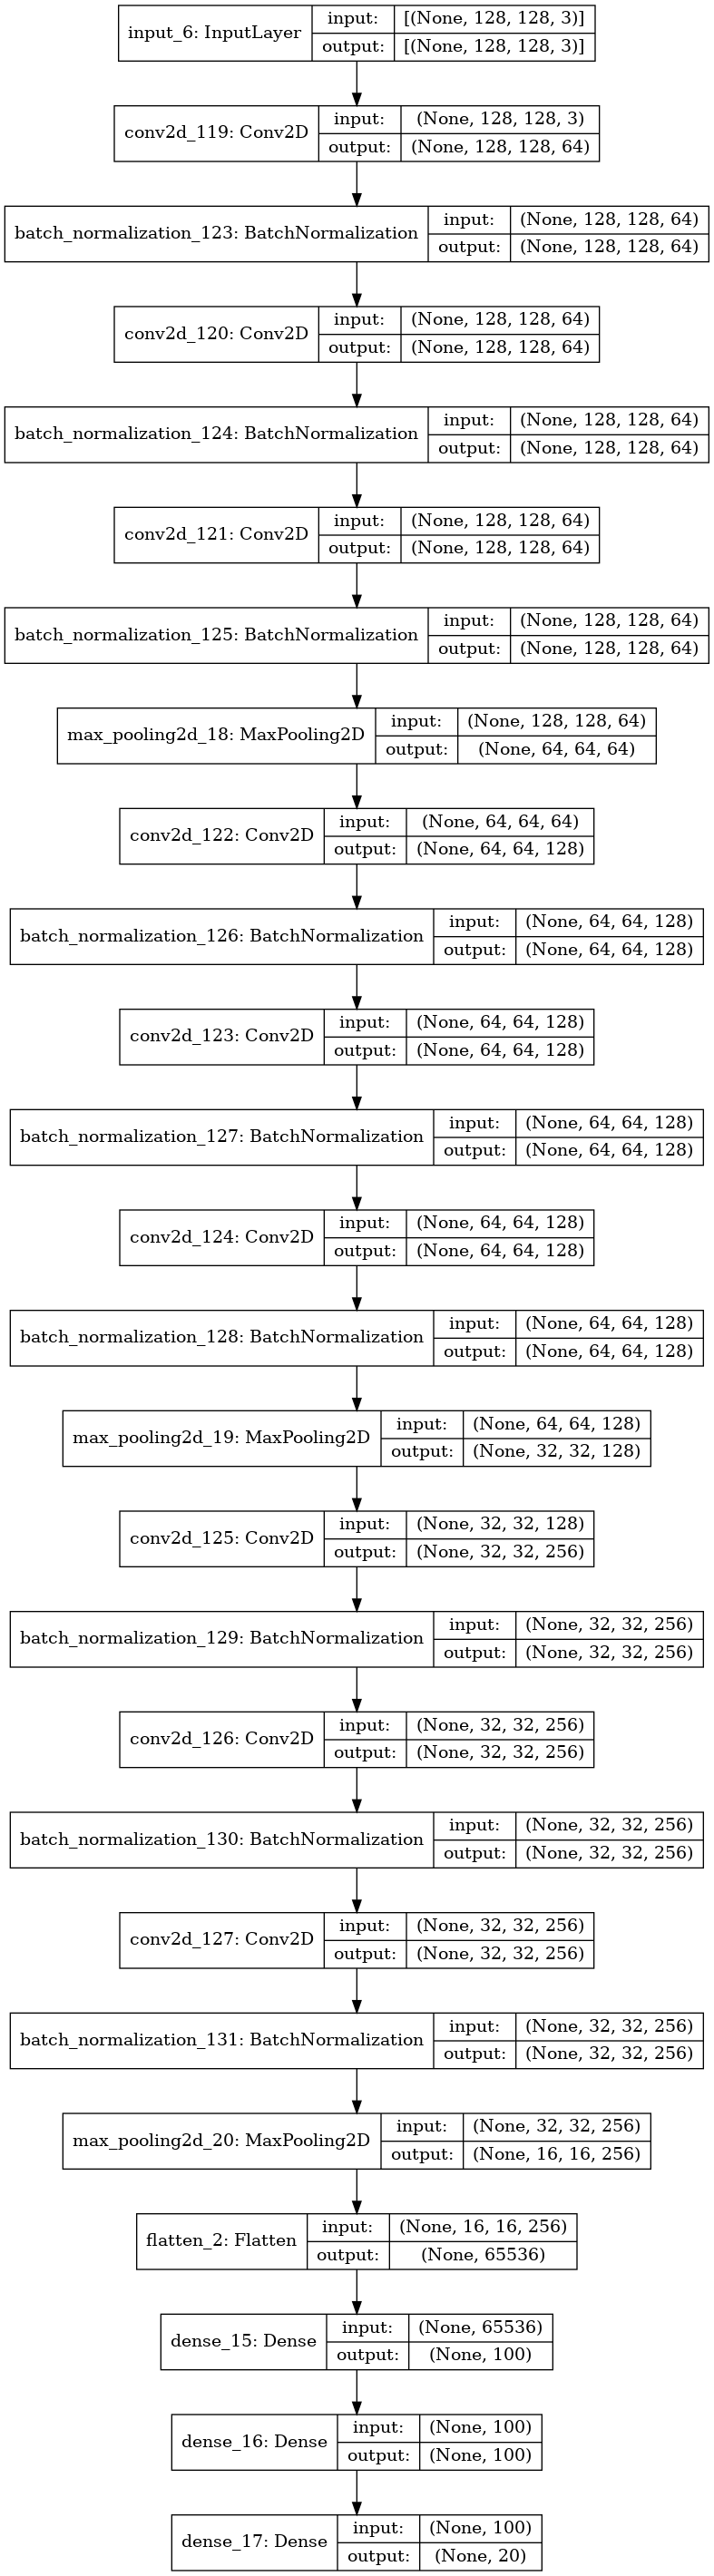

In [31]:
vgg_config = dict()
vgg_config['input_shape'] = (128,128,3)
vgg_config['vgg_layers'] = [3,3,3]
vgg_config['filters'] = [64,128,256]
vgg_config['hidden_layers'] = [100,100]
vgg_config['output_shape'] = 20
# Output activation = always sigmoid
# All convolution layers have 3x3 kernel and same padding
# All pooling layers (end of VGG block) reduce image size by half
# All hidden layers activated with ReLU
# Optimizer is always sgd with lr = 0.01 and momentum=0.9

vgg_model = create_vgg(vgg_config)

tf.keras.utils.plot_model(vgg_model,show_shapes=True)

In [32]:
def inception_block(x, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    # 1x1 conv
    conv1 = tf.keras.layers.Conv2D(f1, (1,1), padding='same', activation='relu')(x)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    # 3x3 conv
    conv3 = tf.keras.layers.Conv2D(f2_in, (1,1), padding='same', activation='relu')(x)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = tf.keras.layers.Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    # 5x5 conv
    conv5 = tf.keras.layers.Conv2D(f3_in, (1,1), padding='same', activation='relu')(x)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv5 = tf.keras.layers.Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    # 3x3 max pooling
    pool = tf.keras.layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
    pool = tf.keras.layers.Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
    pool = tf.keras.layers.BatchNormalization()(pool)
    # concatenate filters, assumes filters/channels last
    layer_out = tf.keras.layers.concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out

def create_inception(config):
    config['num_layers'] = len(config['inception_layers'])
    input = tf.keras.layers.Input(shape=config['input_shape'])
    x = tf.keras.layers.Conv2D(64, (7,7), padding='valid', activation='relu', strides=(2,2))(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

    x = tf.keras.layers.Conv2D(128, (1,1), padding='same', activation='relu', strides=(1,1))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(192, (3,3), padding='same', activation='relu', strides=(1,1))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

    for i in range(config['num_layers']):
        for j in range(config['inception_layers'][i]):
            x = inception_block(x,config['f1'][i][j],config['f2_in'][i][j],config['f2_out'][i][j],
                                                    config['f3_in'][i][j],config['f3_out'][i][j],config['f4_out'][i][j])
        x = tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(x)
    x = tf.keras.layers.Flatten()(x)
    config['num_hidden_layers'] = len(config['hidden_layers'])
    for i in range(config['num_hidden_layers']):
        dim = config['hidden_layers'][i]
        act = 'relu'
        x = tf.keras.layers.Dense(dim,activation=act)(x)

    x = tf.keras.layers.Dense(config['output_shape'],activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=x)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                                optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                                metrics=['accuracy'])
    return model

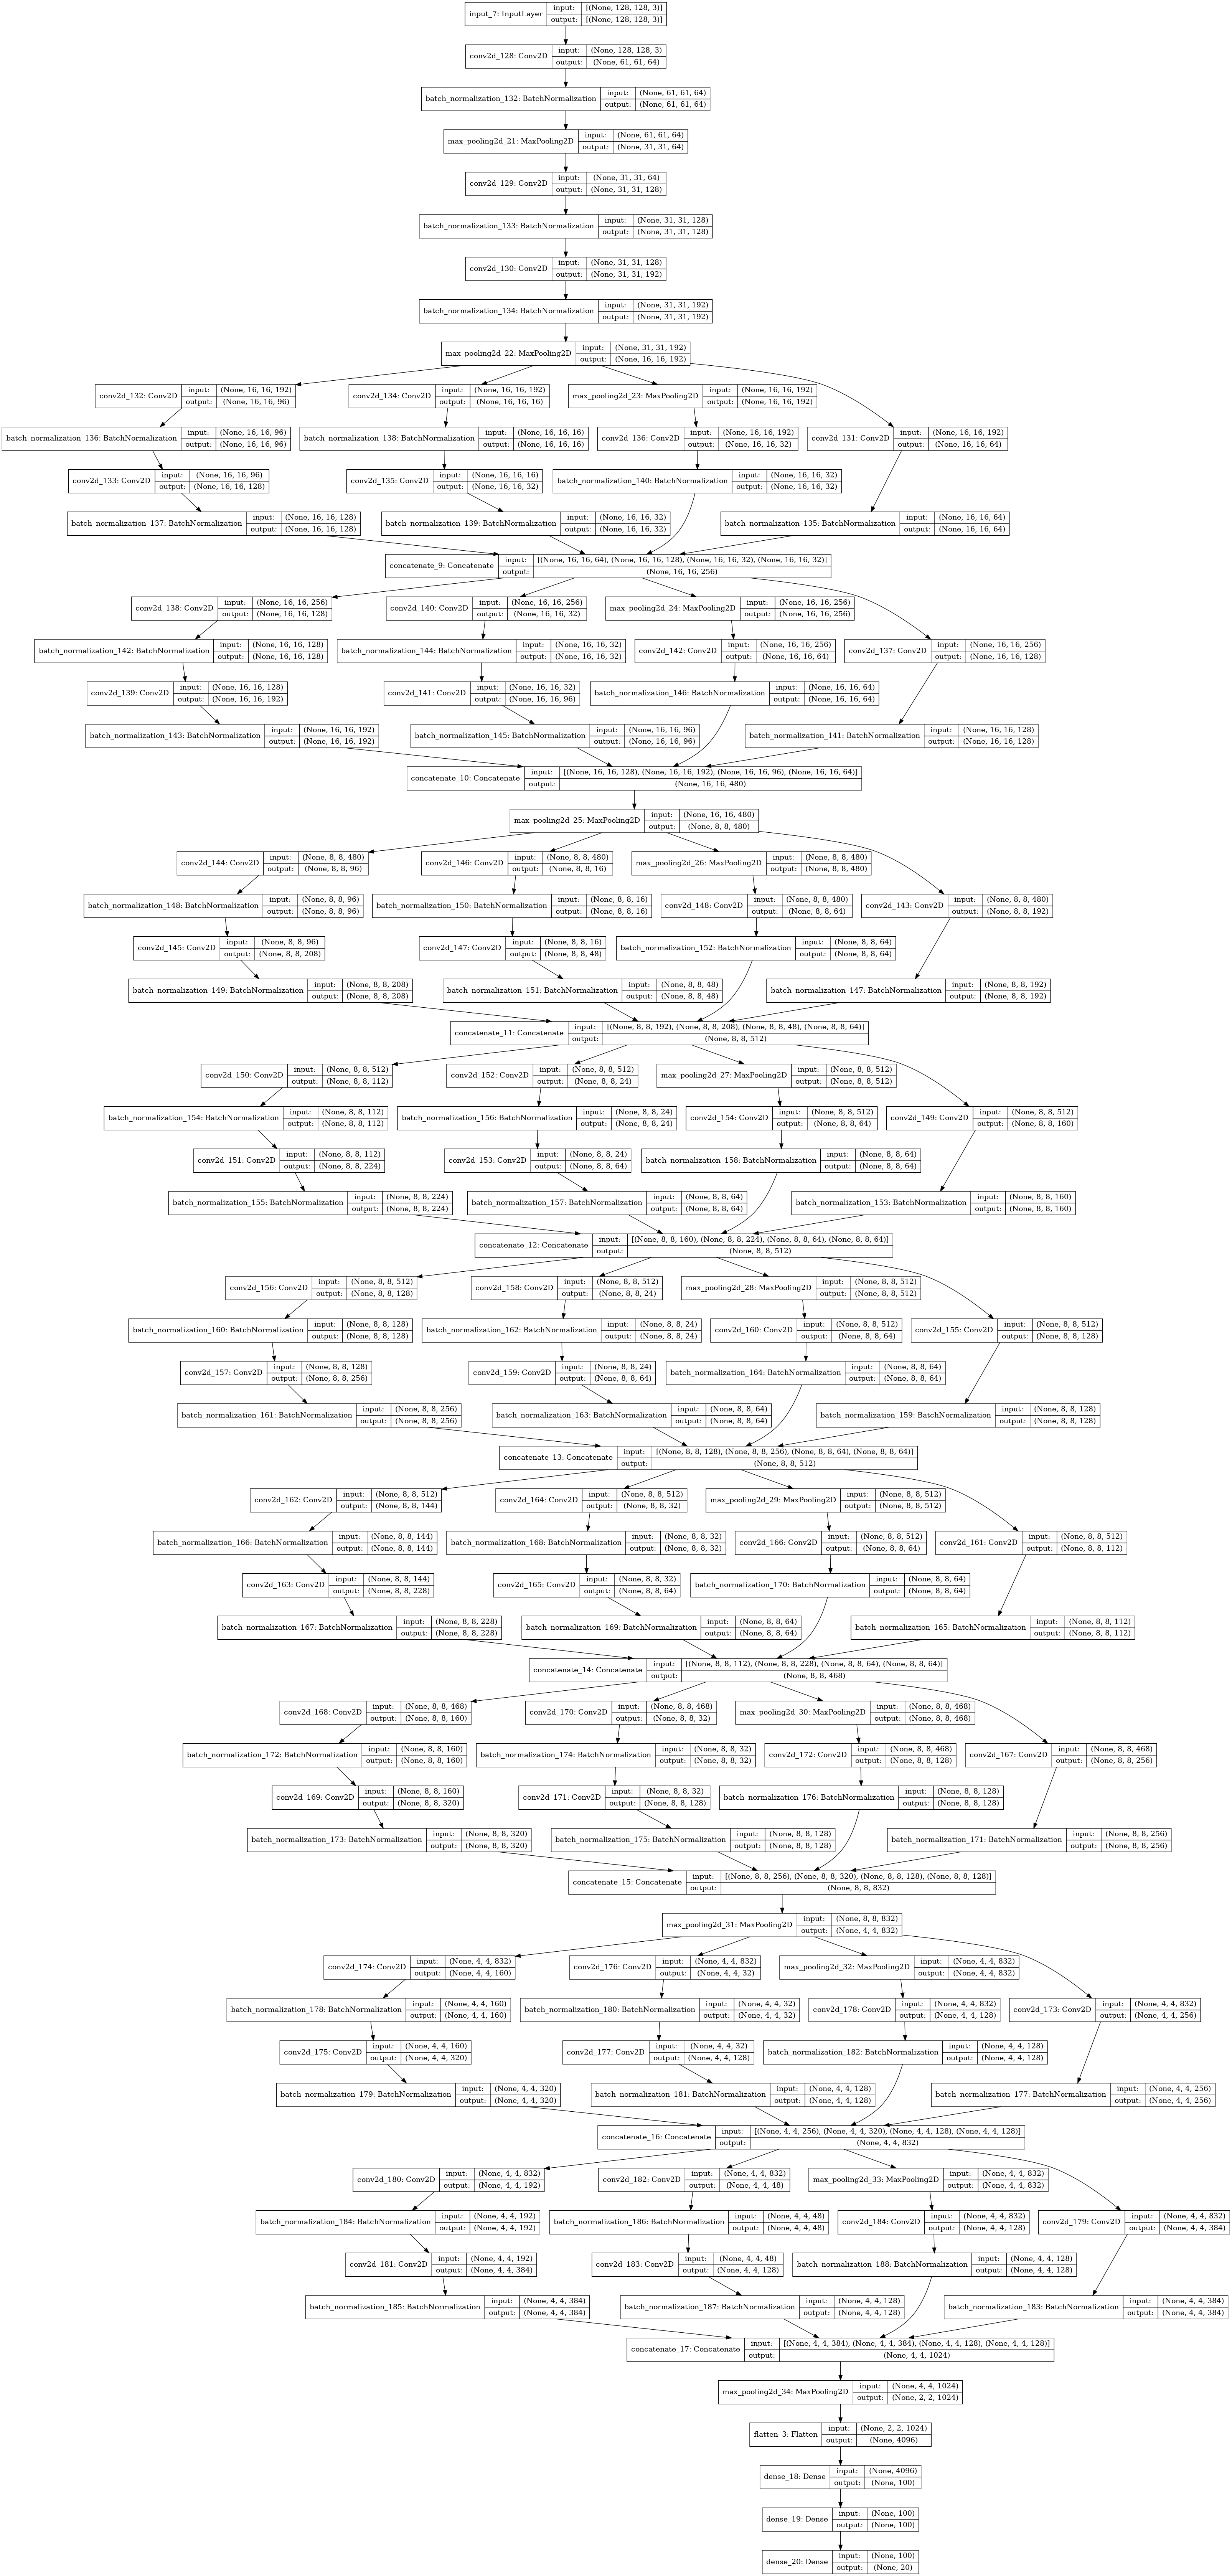

In [33]:
inception_config = dict()
inception_config['input_shape'] = (128,128,3)
inception_config['inception_layers'] = [2,5,2]
inception_config['f1'] = [[64,128],[192,160,128,112,256],[256,384]]
inception_config['f2_in'] = [[96,128],[96,112,128,144,160],[160,192]]
inception_config['f2_out'] = [[128,192],[208,224,256,228,320],[320,384]]
inception_config['f3_in'] = [[16,32],[16,24,24,32,32],[32,48]]
inception_config['f3_out'] = [[32,96],[48,64,64,64,128],[128,128]]
inception_config['f4_out'] = [[32,64],[64,64,64,64,128],[128,128]]
inception_config['hidden_layers'] = [100,100]
inception_config['output_shape'] = 20
# Output activation = always sigmoid
# All convolution layers have 3x3 kernel and same padding
# All pooling layers (end of VGG block) reduce image size by half
# All hidden layers activated with ReLU
# Optimizer is always sgd with lr = 0.01 and momentum=0.9

inception_model = create_inception(inception_config)

tf.keras.utils.plot_model(inception_model,show_shapes=True)

In [34]:
def conv_relu(x, filters, kernel_size, strides=1):
        
        x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding = 'same')(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.BatchNormalization()(x)
        return x

def identity_block(tensor, filters):
        
        x = conv_relu(tensor, filters=filters, kernel_size=1, strides=1)
        x = conv_relu(x, filters=filters, kernel_size=3, strides=1)
        x = tf.keras.layers.Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        
        x = tf.keras.layers.Add()([tensor,x])
        x = tf.keras.layers.ReLU()(x)
        
        return x

def identity_block_small(tensor, filters):
        
        x = conv_relu(tensor, filters=filters, kernel_size=3, strides=1)
        x = conv_relu(x, filters=filters, kernel_size=3, strides=1)
        
        x = tf.keras.layers.Add()([tensor,x])
        x = tf.keras.layers.ReLU()(x)
        
        return x

def projection_block(tensor, filters, strides):
        
        x = conv_relu(tensor, filters=filters, kernel_size=1, strides=strides)
        x = conv_relu(x, filters=filters, kernel_size=3, strides=1)
        x = tf.keras.layers.Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        
        shortcut = tf.keras.layers.Conv2D(filters=4*filters, kernel_size=1, strides=strides)(tensor)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
        
        x = tf.keras.layers.Add()([shortcut,x])
        x = tf.keras.layers.ReLU()(x)
        
        return x

def projection_block_small(tensor, filters, strides):
        
        x = conv_relu(tensor, filters=filters, kernel_size=3, strides=strides)
        x = conv_relu(x, filters=filters, kernel_size=3, strides=1)
        
        shortcut = tf.keras.layers.Conv2D(filters=filters, kernel_size=1, strides=strides)(tensor)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
        
        x = tf.keras.layers.Add()([shortcut,x])
        x = tf.keras.layers.ReLU()(x)
        
        return x

def resnet_block(x, filters, reps, strides):
        
        x = projection_block(x, filters, strides)
        for _ in range(reps-1):
                x = identity_block(x,filters)
                
        return x

def resnet_block_small(x, filters, reps, strides):
        
        x = projection_block_small(x, filters, strides)
        for _ in range(reps):
                x = identity_block_small(x,filters)
                
        return x

def resnet(config):

    input = tf.keras.layers.Input(shape=config['input_shape'])

    x = conv_relu(input, filters=64, kernel_size=7, strides=2)
    x = tf.keras.layers.MaxPool2D(pool_size = 3, strides =2)(x)
    if config['small']==False:
            x = resnet_block(x, filters=64, reps=config['resnet_layers'][0], strides=1)
            x = resnet_block(x, filters=128, reps=config['resnet_layers'][1], strides=2)
            x = resnet_block(x, filters=256, reps=config['resnet_layers'][2], strides=2)
            x = resnet_block(x, filters=512, reps=config['resnet_layers'][3], strides=2)
    else:
            x = resnet_block_small(x, filters=64, reps=config['resnet_layers'][0], strides=1)
            x = resnet_block_small(x, filters=128, reps=config['resnet_layers'][1], strides=2)
            x = resnet_block_small(x, filters=256, reps=config['resnet_layers'][2], strides=2)
            x = resnet_block_small(x, filters=512, reps=config['resnet_layers'][3], strides=2)
    x = tf.keras.layers.GlobalAvgPool2D()(x)

    config['num_hidden_layers'] = len(config['hidden_layers'])
    for i in range(config['num_hidden_layers']):
        dim = config['hidden_layers'][i]
        act = 'relu'
        x = tf.keras.layers.Dense(dim,activation=act)(x)

    output = tf.keras.layers.Dense(config['output_shape'], activation ='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=output)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                            optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                            metrics=['accuracy'])
    return model

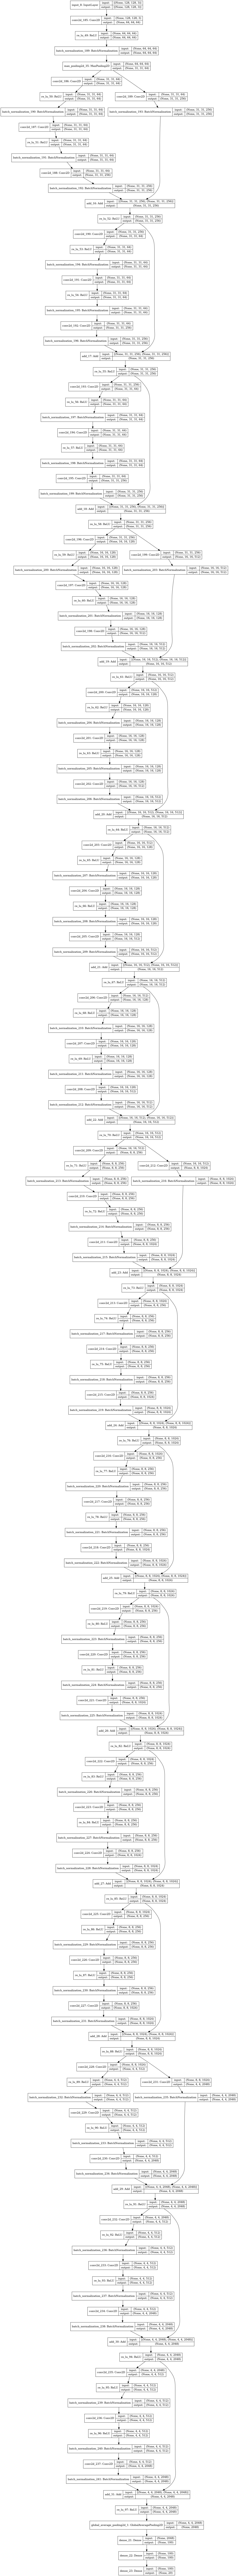

In [35]:
resnet_config = dict()
resnet_config['input_shape'] = (128,128,3)
resnet_config['small'] = False
resnet_config['resnet_layers'] = [3,4,6,3]
resnet_config['hidden_layers'] = [100,100]
resnet_config['output_shape'] = 20
resnet_model = resnet(resnet_config)
# Output activation = always sigmoid
# All resnet blocks have same structure. Can only specify number of repeating blocks (4 list)
# Can also specify if small architecture or not (refer paper)
# All hidden layers activated with ReLU
# Optimizer is always sgd with lr = 0.01 and momentum=0.9

tf.keras.utils.plot_model(resnet_model,show_shapes=True)

In [36]:
tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()['output']

'stdout'

In [37]:
def get_flops(model, batch_size=None,allowed_flops=['MatMul', 'Mul', 'Rsqrt', 'BiasAdd', 'Sub', 'Softmax', 'Conv2D', 'MaxPool', 'Mean']):
    if batch_size is None:
        batch_size = 1

    real_model = tf.function(model).get_concrete_function(tf.TensorSpec([batch_size] + model.inputs[0].shape[1:], model.inputs[0].dtype))
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(real_model)

    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    opts['output'] = 'none'
    flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph,
                                            run_meta=run_meta, cmd='op', options=opts)
    
    ret_val = dict()
    for fl in allowed_flops:
        ret_val[fl] = 0
    f = flops.children
    while(len(f) > 0):
        if f[0].name in allowed_flops:
            ret_val[f[0].name] = f[0].total_float_ops
        f = f[0].children
    return ret_val

In [38]:
def get_weights(model):
    ret_val = dict()
    ret_val['trainable'] = np.sum([np.product([xi for xi in x.get_shape()]) for x in model.trainable_weights])
    ret_val['non_trainable'] = np.sum([np.product([xi for xi in x.get_shape()]) for x in model.non_trainable_weights])
    return ret_val

In [39]:
def get_layers(model):
    ret_val = dict()
    for l in model.layers:
        name = l.__class__.__name__
        if name in ret_val:
            ret_val[name] += 1
        else:
            ret_val[name] = 1
    return ret_val

In [40]:
allowed_flops = ['MatMul', 'Mul', 'Rsqrt', 'BiasAdd', 'Sub', 'Softmax', 'Conv2D', 'MaxPool', 'Mean']
def get_model_params(model,batch_size = 64,x_shape=[]):
    flops = get_flops(model)
    weights = get_weights(model)
    layers = get_layers(model)
    
    print(flops)
    print(weights)
    print(layers)

In [41]:
get_model_params(vgg_model)

2021-12-04 03:59:51.698497: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2021-12-04 03:59:51.698946: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-12-04 03:59:51.701963: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38464 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0
2021-12-04 03:59:51.707930: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1137] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.053ms.
  function_optimizer: function_optimizer did nothing. time = 0.002ms.



{'MatMul': 20471552, 'Mul': 0, 'Rsqrt': 0, 'BiasAdd': 7340352, 'Sub': 0, 'Softmax': 100, 'Conv2D': 8532811520, 'MaxPool': 1835108, 'Mean': 0}
{'trainable': 8488508, 'non_trainable': 2688}
{'InputLayer': 1, 'Conv2D': 9, 'BatchNormalization': 9, 'MaxPooling2D': 3, 'Flatten': 1, 'Dense': 3}


In [42]:
vgg_config['input_shape'] = (128,128,3)
vgg_config['vgg_layers'] = [3,3,3]
vgg_config['filters'] = [64,128,256]
vgg_config['hidden_layers'] = [100,100]
vgg_config['output_shape'] = 20

In [43]:
vgg_range = dict()
vgg_range['input_shape'] = [128,1024,15,0]
vgg_range['input_size'] = [10,20,15,1] # Logspace 9
vgg_range['vgg_layers'] = [2,10,9,0]
vgg_range['vgg_layers_size'] = [1,10,10,0] 
vgg_range['filters'] = [4,11,8,1] # Logspace 8
vgg_range['hidden_layers_size'] = [1,10,10,0]
vgg_range['hidden_layers'] = [2,5,7,2] # Logspace 7
vgg_range['output_shape'] = [1,10,10,1] # Logspace 10
vgg_range['batch_size'] = [3,10,8,1] #Logspace 8

In [44]:
for key in vgg_range.keys():
    val = vgg_range[key]
    print(key,":","",end='')
    if val[-1] == 0:
        x = np.linspace(val[0],val[1],num=val[2]).astype('int')
        print(x)
    elif val[-1] == 1:
        x = np.logspace(val[0],val[1],num=val[2],base=2).astype('int')
        print(x)
    elif val[-1] == 2:
        x = np.logspace(val[0],val[1],num=val[2],base=10).astype('int')
        print(x)

input_shape : [ 128  192  256  320  384  448  512  576  640  704  768  832  896  960
 1024]
input_size : [   1024    1680    2756    4522    7419   12173   19972   32768   53761
   88204  144715  237430  389544  639114 1048576]
vgg_layers : [ 2  3  4  5  6  7  8  9 10]
vgg_layers_size : [ 1  2  3  4  5  6  7  8  9 10]
filters : [  16   32   64  128  256  512 1024 2048]
hidden_layers_size : [ 1  2  3  4  5  6  7  8  9 10]
hidden_layers : [   100    316   1000   3162  10000  31622 100000]
output_shape : [   2    4    8   16   32   64  128  256  512 1024]
batch_size : [   8   16   32   64  128  256  512 1024]


In [21]:
vgg_model

In [58]:
%%time
x = np.ones((100,128,128,3))
y = np.random.rand(100,20)

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=30, 
                                                          fill_mode='nearest',
                                                         )

history = vgg_model.fit_generator(datagen.flow(x,y,batch_size=64), epochs=6, steps_per_epoch=1048576 // 64)

Epoch 1/6
16384/16384 [==============================] - 3s 84us/step - loss: nan - accuracy: 0.0400
CPU times: user 2.69 s, sys: 443 ms, total: 3.13 s
Wall time: 2.91 s


In [75]:
x_train = tf.data.Dataset.from_tensor_slices([x,y]).repeat().as_numpy_iterator()

ValueError: Can't convert non-rectangular Python sequence to Tensor.

In [69]:
vgg_model.fit(x_train, epochs=6, steps_per_epoch=1048576 // 64)

ValueError: `y` argument is not supported when using python generator as input.

In [ ]:
vgg_model.fit(x,y,epochs=6)

In [73]:
datagen.flow(x,y,batch_size=64).next()

(array([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         ...,
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]],
 
 
        [

### Planned parameters : 

1. Number of cov layers
2. Number of dense layers
3. Number of total layers

4. Conv2D flops
5. MaxPool flops
6. Bias Addition flops
8. Matrix Multiplication flops
7. Mean Flops
8. Softmax Flops

9. Dataset shape (image - max(width,height), fc - input dimension)
10. Number of training images
11. Output dimensions
----------
12. Model Type
13. Batch Size

Include Batch norm (after every layer)

### Models

1. Fully connected

fc_config['input_shape'] = 1000 <br>
fc_config['output_shape'] = 10 <br>
fc_config['input_dropout'] = 0.2 <br>
fc_config['dropout'] = 0.5 <br>
fc_config['hidden_layers'] = 2 <br>
fc_config['layers'] = [1000,1000] <br>

2. VGG

vgg_config['input_shape'] = (128,128,3) <br>
vgg_config['vgg_layers'] = [3,3,3] <br>
vgg_config['filters'] = [64,128,256] <br>
vgg_config['hidden_layers'] = [100,100] <br>
vgg_config['output_shape'] = 20 <br>

3. Inception Network

inception_config['input_shape'] = (128,128,3) <br>
inception_config['inception_layers'] = [2,5,2] <br>
inception_config['f1'] = [[64,128],[192,160,128,112,256],[256,384]] <br>
inception_config['f2_in'] = [[96,128],[96,112,128,144,160],[160,192]] <br>
inception_config['f2_out'] = [[128,192],[208,224,256,228,320],[320,384]] <br>
inception_config['f3_in'] = [[16,32],[16,24,24,32,32],[32,48]] <br>
inception_config['f3_out'] = [[32,96],[48,64,64,64,128],[128,128]] <br>
inception_config['f4_out'] = [[32,64],[64,64,64,64,128],[128,128]] <br>
inception_config['hidden_layers'] = [100,100] <br>
inception_config['output_shape'] = 20 <br>

4. Resnet

resnet_config['input_shape'] = (128,128,3) <br>
resnet_config['small'] = False <br>
resnet_config['resnet_layers'] = [3,4,6,3] <br>
resnet_config['hidden_layers'] = [100,100] <br>
resnet_config['output_shape'] = 20 <br>
resnet_model = resnet(resnet_config) <br>